Aggregating data to the level of individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
from bsmcalls import individuals
from bsmcalls import readVCF
from bsmcalls import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import fwsel
import re
import attila_utils

Import calls and clinical data and filter for NeuN+ samples

Import data and drop columns with any `NA`s

In [2]:
fpath = '/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.csv'
D = pd.read_csv(fpath, index_col=['Individual ID', 'Tissue', 'CHROM', 'POS', 'Mutation'])
before = D.shape
D = D.dropna(axis=1)
after = D.shape
print('Columns before and after NA drop')
print('before', before[1])
print('after', after[1])

Columns before and after NA drop
before 149
after 63


In [3]:
Dcols = D.columns
if D.select_dtypes('object').shape[1]:
    Dcateg = D.select_dtypes('object').astype('category')
    Dnum = D.drop(columns=Dcateg.columns)
    D = pd.concat([Dcateg, Dnum], axis=1)
    D = D[Dcols]

In [4]:
D.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3411 entries, ('CMC_MSSM_027', 'NeuN_pl', '1', 11973569, 'C/T') to ('CMC_MSSM_331', 'muscle', '17', 29109599, 'T/G')
Data columns (total 63 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   REF                                            3411 non-null   category
 1   ALT                                            3411 non-null   category
 2   QUAL                                           3411 non-null   float64 
 3   FILTER/PASS                                    3411 non-null   category
 4   FILTER/HC                                      3411 non-null   category
 5   FILTER/EXT                                     3411 non-null   category
 6   AC                                             3411 non-null   int64   
 7   AF                                             3411 non-null   float64 
 8   AN                       

The `AN` (allele number) column is invariably 50 thus it is a degenerate random variable.  I found that including it leads to an error in the forward feature selection algorithm.

In [5]:
D = D.drop(columns='AN')
D = D[[s for s in D.columns if not re.match('^near_gens.*', s)]]
D.shape

(3411, 53)

In [6]:
D = D.loc(axis=0)[:, 'NeuN_pl']
D.shape

(3383, 53)

In [7]:
clin_cols = D.loc[:, 'Institution':'Illicitsub'].columns
Dcalls = D.drop(columns=clin_cols)
aggcalls = individuals.agg_calls(Dcalls)

In [8]:
calls, clin = individuals.get_data(merge=False)
data = pd.concat([aggcalls, clin], axis=1)

In [9]:
aggcalls

Variable      nCalls        QUAL                     AC                  AF  \
Transform      count        mean          std      mean       std      mean   
Individual ID                                                                 
CMC_MSSM_027      56  493.074643   796.091443  4.714286  5.502774  0.094286   
CMC_MSSM_055      49  251.496735   548.849252  2.346939  3.419009  0.046939   
CMC_MSSM_056       9  160.207778    84.631748  4.111111  2.027588  0.082222   
CMC_MSSM_069      12  164.519167    71.714983  5.333333  1.614330  0.106667   
CMC_MSSM_097      96  805.140938  1770.829133  3.906250  6.556761  0.078125   
...              ...         ...          ...       ...       ...       ...   
CMC_PITT_098      26  385.486154   275.980395  5.115385  2.984318  0.102308   
CMC_PITT_101      13  437.868462   543.456576  6.153846  4.634043  0.123077   
CMC_PITT_113      33  818.622121  1607.862054  5.151515  7.973084  0.103030   
CMC_PITT_117      17  394.947059   468.976246  4.823529  4.347920  0.096471   
CMC_PITT_118      42  283.720476   288.308424  3.309524  2.709406  0.066190   

Variable                BaseQRankSum                    DP  ...  \
Transform           std         mean       std        mean  ...   
Individual ID                                               ...   
CMC_MSSM_027   0.110055     1.394286  2.469961  202.892857  ...   
CMC_MSSM_055   0.068380     2.242102  2.001271  255.020408  ...   
CMC_MSSM_056   0.040552     1.131333  2.036603  104.222222  ...   
CMC_MSSM_069   0.032287    -0.287417  2.675964   58.916667  ...   
CMC_MSSM_097   0.131135     1.063500  2.669541  372.781250  ...   
...                 ...          ...       ...         ...  ...   
CMC_PITT_098   0.059686     0.961385  1.958133  161.230769  ...   
CMC_PITT_101   0.092681     1.000154  1.917042  130.769231  ...   
CMC_PITT_113   0.159462     0.546909  3.012843  251.727273  ...   
CMC_PITT_117   0.086958     1.080529  1.835480  182.411765  ...   
CMC_PITT_118   0.054188     0.841714  2.103925  221.452381  ...   

Variable      ensembl_Predicted Function regbuild_Epigenome            \
Transform                        entropy          marg_mode frequency   
Individual ID                                                           
CMC_MSSM_027                    1.391173              other  0.785714   
CMC_MSSM_055                    1.188578              other  0.795918   
CMC_MSSM_056                    0.936888              other  0.888889   
CMC_MSSM_069                    1.143708              other  0.833333   
CMC_MSSM_097                    1.345125              other  0.750000   
...                                  ...                ...       ...   
CMC_PITT_098                    1.144717              other  0.769231   
CMC_PITT_101                    0.617242              other  0.769231   
CMC_PITT_113                    1.361973              other  0.666667   
CMC_PITT_117                    1.230699              other  0.823529   
CMC_PITT_118                    1.155143              other  0.833333   

Variable                sift_Prediction                     structvar_Type  \
Transform       entropy       marg_mode frequency   entropy      marg_mode   
Individual ID                                                                
CMC_MSSM_027   0.519580           other  0.946429  0.208900           loss   
CMC_MSSM_055   0.506009           other  0.959184  0.198822           loss   
CMC_MSSM_056   0.348832           other  1.000000  0.000000           loss   
CMC_MSSM_069   0.450561           other  1.000000  0.000000           loss   
CMC_MSSM_097   0.562335           other  0.968750  0.158952           loss   
...                 ...             ...       ...       ...            ...   
CMC_PITT_098   0.540204           other  1.000000  0.000000           loss   
CMC_PITT_101   0.540204           other  1.000000  0.000000           loss   
CMC_PITT_113   0.636514           other  1.000000  0.000000           los

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, CMC_MSSM_027 to CMC_PITT_118
Columns: 111 entries, ('nCalls', 'count') to EV.5
dtypes: category(13), float64(85), int64(1), object(12)
memory usage: 68.9+ KB


### Correlations

['named-figure/corrmat-indiv-based.png',
 'named-figure/corrmat-indiv-based.pdf']

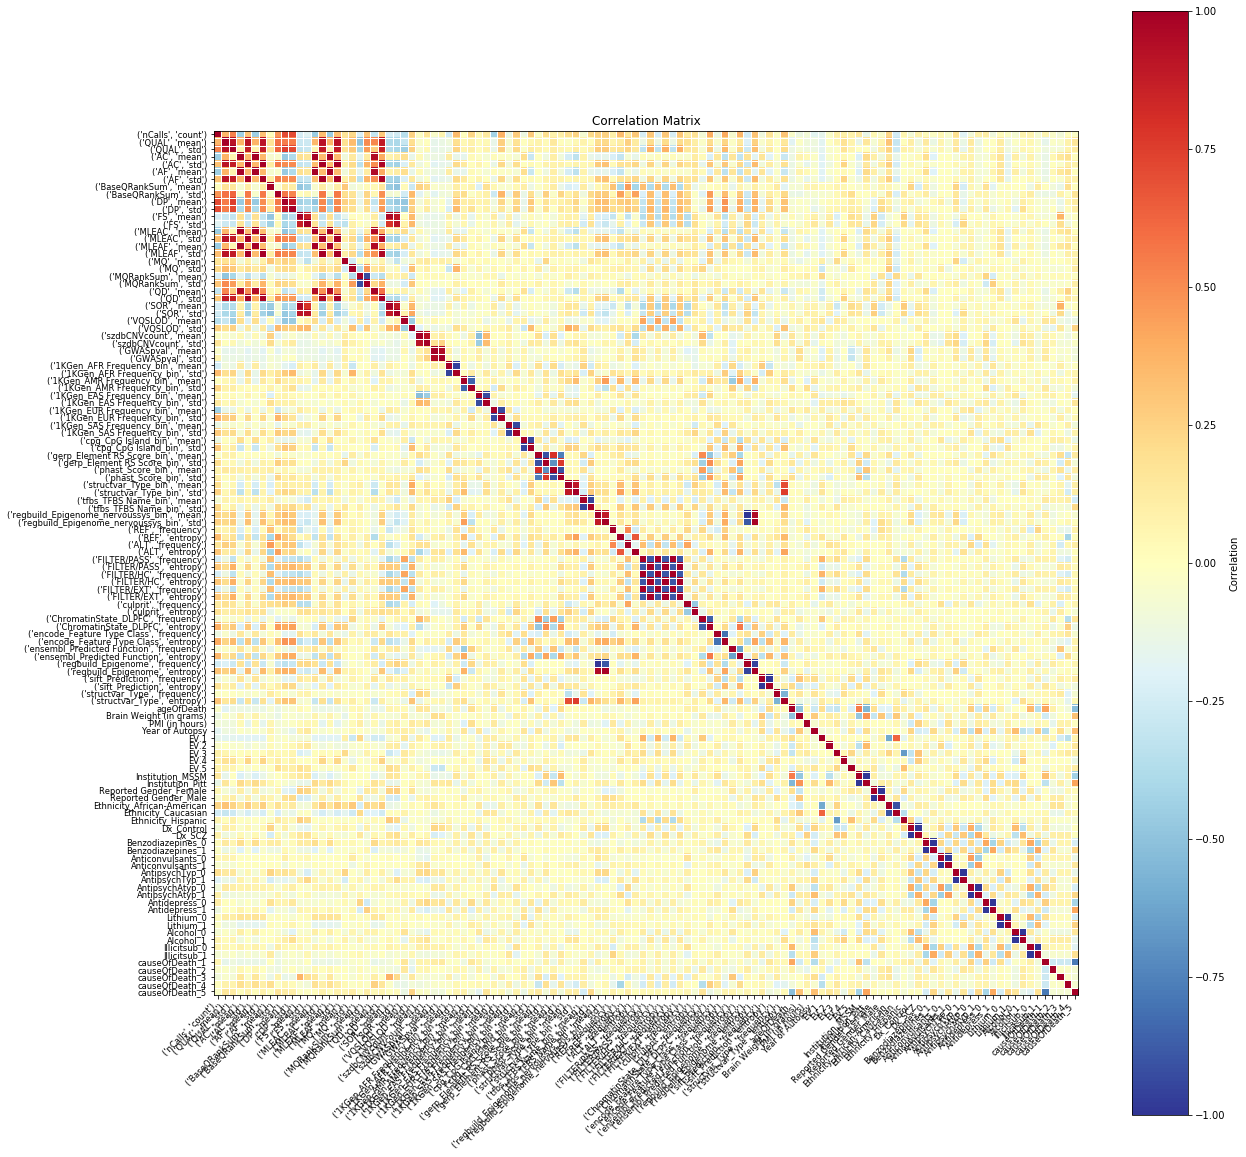

In [11]:
datanum = preprocessing.dummify_df(data)
def corrmatplot(dfnum, fsize=18):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(fsize,fsize))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=corrmat.columns, ynames=corrmat.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))
fig, ax = corrmatplot(datanum)
attila_utils.savefig(fig, 'corrmat-indiv-based')

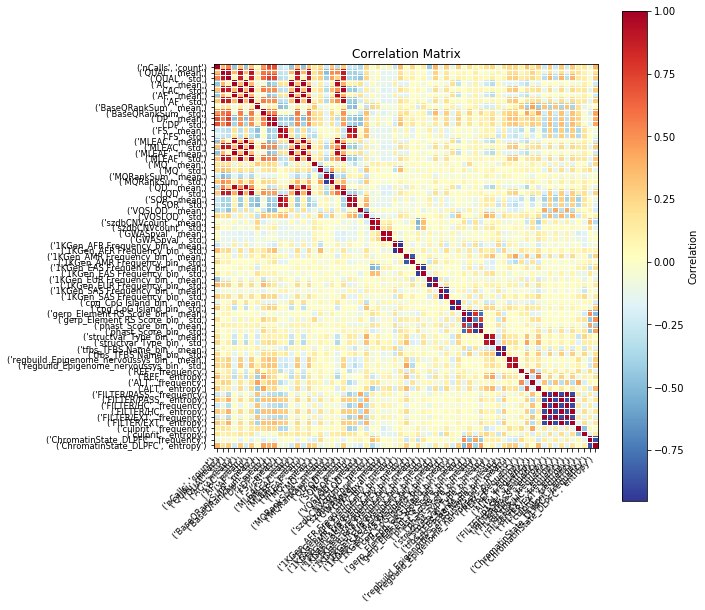

In [12]:
fig, ax = corrmatplot(datanum.loc[:, :('ChromatinState_DLPFC', 'entropy')])
fig.set_size_inches(8, 8)

In [13]:
collinear_cols = ['DP_std', 'FS_std', 'SOR_mean', 'SOR_std', 'szdbCNVcount_std', 'GWASpval_std']

In [14]:
def preprocess_filter(data, c2d=collinear_cols):
    data1 = preprocessing.preprocess(data)
    # we remove the marginal modes since these are all degenerate variables
    cols2drop = [y for y in data1.columns if re.match('.*_marg_mode', y)]
    cols2drop += [y for y in data1.columns if re.match('.*_frequency', y)]
    cols2drop += [y for y in data1.columns if re.match('.*_std', y)]
    cols2drop += [y for y in data1.columns if re.match('^1KGen_.*', y)]
    data1 = data1.drop(columns=cols2drop + c2d)
    return(data1)

data1 = preprocess_filter(data, c2d=[]) # we omit the removing of collinear_cols

## Simple univariate regression

Fitting logit
Optimization terminated successfully.
         Current function value: 0.558083
         Iterations 7
Fitting probit
Optimization terminated successfully.
         Current function value: 0.557065
         Iterations 6


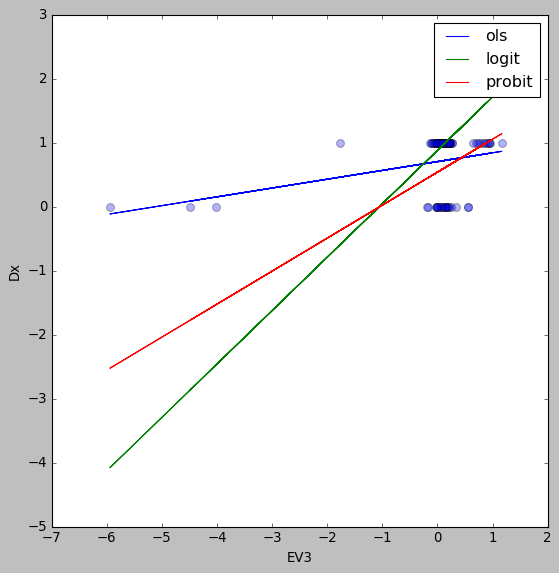

In [15]:
%matplotlib inline
plt.style.use('classic')

def simple_reg(sel_col='EV3', data=data1):
    f = 'Dx ~ ' + sel_col
    lin = smf.ols(formula=f, data=data1).fit()
    print('Fitting logit')
    logi = smf.logit(formula=f, data=data1).fit()
    print('Fitting probit')
    probi = smf.probit(formula=f, data=data1).fit()
    #p = sm.graphics.plot_regress_exog(lin, sel_col)
    fig, ax = plt.subplots(figsize=(8, 8))
    data.plot(x=sel_col, y='Dx', kind='scatter', alpha=0.3, s=50, marker='o', ax=ax)
    ax.plot(data[sel_col].values, lin.fittedvalues.values, label='ols')
    ax.plot(data[sel_col].values, logi.fittedvalues.values, label='logit')
    ax.plot(data[sel_col].values, probi.fittedvalues.values, label='probit')
    ax.legend()
    return((lin, logi, probi))

mm = simple_reg('EV3')

Fitting logit
Optimization terminated successfully.
         Current function value: 0.599428
         Iterations 5
Fitting probit
Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 5


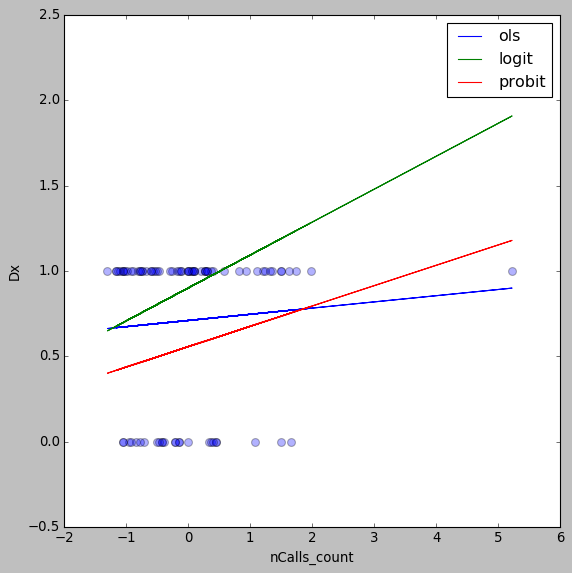

In [16]:
mm = simple_reg('nCalls_count', data=data1)

## Modeling: nCalls as response

The idea is to use the nCalls variable as response.  Benefits include:
* nCalls is better suited for linear modeling since it can be considered as a continuous response variable
* technical variables that affect nCalls such as read depth (see below) can be incorporated into the model

### Visual exploration

Text(0.5, 0.98, 'no. calls and read depth')

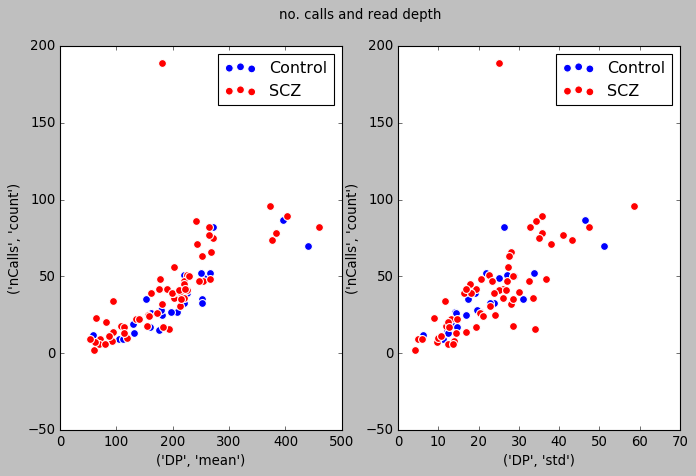

In [17]:
def myscatter(ax, x=('DP', 'mean'), y=('nCalls', 'count')):
    df = data.loc[data['Dx'] == 'Control', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='Control', c='b', edgecolors='white', s=50)
    df = data.loc[data['Dx'] == 'SCZ', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='SCZ', c='r', edgecolors='white', s=50)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.legend()
    return(ax)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('DP', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('DP', 'std'), y=('nCalls', 'count'))
fig.suptitle('no. calls and read depth')

['named-figure/numcalls-depth-Dx.png', 'named-figure/numcalls-depth-Dx.pdf']

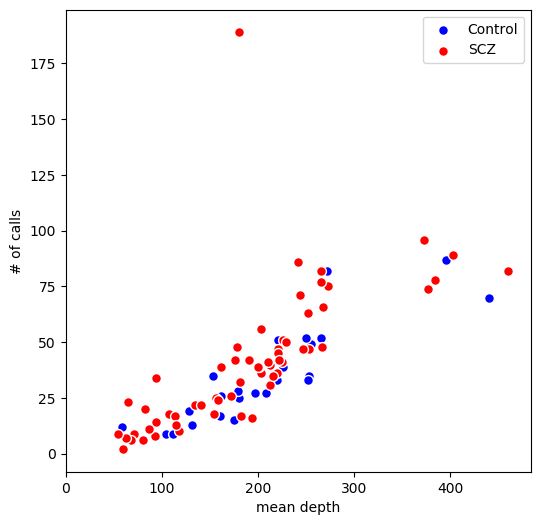

In [18]:
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = myscatter(ax=ax, x=('DP', 'mean'), y=('nCalls', 'count'))
ax.set_xlabel('mean depth')
ax.set_ylabel('# of calls')
ax.set_xlim(0)
attila_utils.savefig(fig, 'numcalls-depth-Dx')

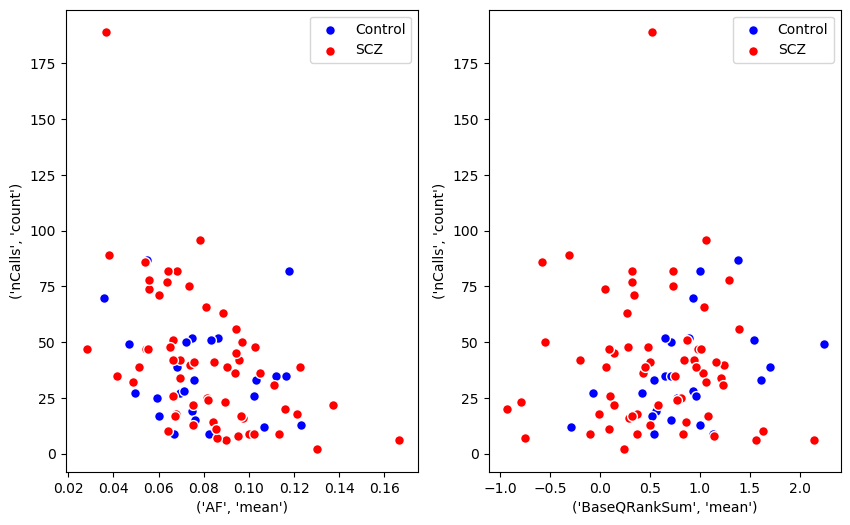

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('AF', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('BaseQRankSum', 'mean'), y=('nCalls', 'count'))

### Finding the outlier

In [20]:
data[('nCalls', 'count')].sort_values()

CMC_MSSM_201      2
CMC_MSSM_266      6
CMC_MSSM_331      6
CMC_MSSM_293      7
CMC_MSSM_308      8
               ... 
CMC_MSSM_343     86
CMC_MSSM_406     87
CMC_MSSM_213     89
CMC_MSSM_097     96
CMC_MSSM_224    189
Name: (nCalls, count), Length: 86, dtype: int64

In [21]:
clin.loc['CMC_MSSM_224']

Institution                            MSSM
Reported Gender                      Female
Ethnicity                  African-American
ageOfDeath                               53
Brain Weight (in grams)                1130
PMI (in hours)                          6.3
Dx                                      SCZ
Year of Autopsy                        2001
Benzodiazepines                           0
Anticonvulsants                           0
AntipsychTyp                              0
AntipsychAtyp                             1
Antidepress                               0
Lithium                                   0
Alcohol                                   0
Illicitsub                                0
causeOfDeath                              1
EV.1                              -0.080551
EV.2                               0.000982
EV.3                               0.035962
EV.4                               0.000456
EV.5                               0.006669
Name: CMC_MSSM_224, dtype: objec

### Forward variables selection

In [22]:
best1 = fwsel.forward_selected(data1, 'nCalls_count')

In [23]:
best1.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + AF_mean + Ethnicity + YearofAutopsy + AntipsychAtyp + ensembl_PredictedFunction_entropy + phast_Score_bin_mean + MQRankSum_mean + Antidepress + BaseQRankSum_mean + gerp_ElementRSScore_bin_mean + encode_FeatureTypeClass_entropy + cpg_CpGIsland_bin_mean + QD_mean + Lithium + GWASpval_mean + szdbCNVcount_mean + sift_Prediction_entropy + Alcohol + ageOfDeath + EV2 + EV1 + Anticonvulsants + 1'

In [24]:
summary1 = best1.summary()
fpath = '/home/attila/projects/bsm/results/2020-08-19-indiv-based-analysis/fwsel-summary1.csv'
with open(fpath, 'wt') as f:
    f.write(summary1.as_csv())
summary1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nCalls_count   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     8.036
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           2.18e-11
Time:                        00:48:52   Log-Likelihood:                -56.456
No. Observations:                  86   AIC:                             166.9
Df Residuals:                      59   BIC:                             233.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.6641      0.238      2.796      0.007       0.189       1.139
ReportedGender[T.Male]               -0.2397      0.163     -1.467      0.148      -0.567       0.087
Ethnicity[T.Caucasian]               -0.4112      0.236     -1.745      0.086      -0.883       0.060
Ethnicity[T.Hispanic]                -0.4142      0.460     -0.900      0.372      -1.335       0.507
AntipsychAtyp[T.1]                    0.1780      0.180      0.990      0.326      -0.182       0.538
Antidepress[T.1]                     -0.5635      0.201     -2.803      0.007      -0.966      -0.161
Lithium[T.1]                         -0.8943      0.631     -1.417      0.162      -2.157       0.368
Alcohol[T.1]                         -0.2555      0.174     -1.470      0.147      -0.603       0.092
Anticonvulsants[T.1]                 -0.2930      0.238     -1.229      0.224      -0.770       0.184
DP_mean                               0.3270      0.106      3.090      0.003       0.115       0.539
culprit_entropy                       0.1049      0.069      1.526      0.132      -0.033       0.243
AF_mean                              -0.7920      0.305     -2.596      0.012      -1.402      -0.181
YearofAutopsy                        -0.1164      0.083     -1.405      0.165      -0.282       0.049
ensembl_PredictedFunction_entropy     0.2053      0.084      2.452      0.017       0.038       0.373
phast_Score_bin_mean                  0.4024      0.138      2.913      0.005       0.126       0.679
MQRankSum_mean                       -0.1732      0.075     -2.297      0.025      -0.324      -0.022
BaseQRankSum_mean                    -0.2462      0.081     -3.049      0.003      -0.408      -0.085
gerp_ElementRSScore_bin_mean         -0.3399      0.138     -2.470      0.016      -0.615      -0.065
encode_FeatureTypeClass_entropy       0.1538      0.084      1.831      0.072      -0.014       0.322
cpg_CpGIsland_bin_mean                0.1543      0.078      1.977      0.053      -0.002       0.311
QD_mean                               0.3874      0.284      1.362      0.178      -0.182       0.957
GWASpval_mean                        -0.1632      0.076     -2.142      0.036      -0.316      -0.011
szdbCNVcount_mean                     0.1484      0.073      2.045      0.045       0.003       0.294
sift_Prediction_entropy              -0.0611      0.077     -0.798      0.428      -0.214       0.092
ageOfDeath                           -0.1676      0.091     -1.850      0.069      -0.349       0.014
EV2                                  -0.1360      0.076     -1.788      0.079      -0.288       0.016
EV1                                  -0.1075      0.087     -1.237      0.221      -0.281       0.066
=======================

## Transcription start sites hypothesis

The above analysis did not suggest involvement of chromatin state in somatic risk variants for schizophrenia.  However, our previous descriptive statistical analysis (2020-06-10-annotate-explore-variants)showed tendency for the enrichment of transcription start sites (TssA and TssAFlnk) in SCZ somatic variants relative to Control.  Why is this discrepancy?

The discrepancy might have arisen because the `ChromatinState_DLPFC` factor has 15 levels thus increases the degrees of freedom by quite a lot (14 to be precise) in regression models.  Here I test this hypothesis by merging the 15 levels into only two levels: one containing TssA and TssAFlnk while the other all the other 13 chromatin states.

In [25]:
calls_tss = calls.copy()
s = calls['ChromatinState_DLPFC']
d = {'TssA': ['TssA', 'TssAFlnk'],  'Other': ['TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 'Het', 'TssBiv', 'ReprPC', 'ReprPCWk', 'Quies']} 
calls_tss['ChromatinState_DLPFC'] = preprocessing.collapse_categories(s, d)

In [26]:
aggcalls_tss = individuals.agg_calls(calls_tss)
data_tss = pd.concat([aggcalls_tss, clin], axis=1)
data2_tss = preprocess_filter(data_tss, c2d=collinear_cols) # we remove collinear_cols

In [27]:
best2_tss = fwsel.forward_selected(data2_tss, 'nCalls_count')

In [28]:
best2_tss.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + Ethnicity + AF_mean + ChromatinState_DLPFC_entropy + YearofAutopsy + AntipsychAtyp + REF_entropy + szdbCNVcount_mean + EV1 + Anticonvulsants + EV3 + 1'

Selected variables in `best2.model` that persisted in `best2_tss.model`:

In [29]:
set(best2_tss.model.exog_names).intersection(set(best2.model.exog_names))

NameError: name 'best2' is not defined

Selected variables in `best2_tss.model` that weren't selected in `best2.model`:

In [ ]:
set(best2_tss.model.exog_names) - set(best2.model.exog_names)

Previously selected variables in `best2.model` that dropped out in `best2_tss.model`:

In [ ]:
set(best2.model.exog_names) - set(best2_tss.model.exog_names)

In [9]:
%connect_info

{
  "shell_port": 43059,
  "iopub_port": 49745,
  "stdin_port": 57967,
  "control_port": 41013,
  "hb_port": 37155,
  "ip": "127.0.0.1",
  "key": "c0963b60-2df071f1785e6eb059ac9cac",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a7eb155c-9092-418f-a82d-e3664d00256f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
